In [9]:
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd

from collections import defaultdict
from tqdm import tqdm

import numpy as np

In [2]:
model = KeyedVectors.load_word2vec_format("F:/SHRINIVAS/KGP/BTP/Meal-Planning/Data/Recipe1M/vocab.bin/vocab.bin", binary=True)

In [10]:
df=pd.read_csv("F:/SHRINIVAS/KGP/BTP/Meal-Planning/Data/MealRec/recipe.csv")

In [11]:
df.head()

,Unnamed: 0,recipe_id,recipe_name,review_nums,category,aver_rate,image_url,ingredients,cooking_directions,nutritions,reviews,tags
0,0,6698,Mom's Zucchini Bread,9355,appetizer,4.754207,https://images.media-allrecipes.com/userphotos...,all-purpose flour^salt^baking soda^baking powd...,{'directions': u'Prep\n20 m\nCook\n1 h\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{9568256: {'rating': 5, 'followersCount': 0, '...",north-american;breads;easy;beginner-cook;inexp...
1,1,6709,Zucchini Walnut Bread,58,appetizer,4.478873,http://images.media-allrecipes.com/userphotos/...,chopped walnuts^eggs^white sugar^vegetable oil...,"{'directions': u'Whisk together flour, baking ...","{u'niacin': {u'hasCompleteData': True, u'name'...","{1636096: {'rating': 4, 'followersCount': 0, '...",weeknight;breads;fruit;vegetables;kid-friendly...
2,2,6725,Honey Wheat Bread I,2054,appetizer,4.766846,http://images.media-allrecipes.com/userphotos/...,rapid rise yeast^white sugar^warm water (110 d...,{'directions': u'Prep\n25 m\nCook\n35 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1542146: {'rating': 4, 'followersCount': 56, ...",healthy;breads;dietary;low-cholesterol;healthy...
3,3,6730,Chocolate Chip Orange Zucchini Bread,503,dessert,4.674833,https://images.media-allrecipes.com/userphotos...,eggs^white sugar^vegetable oil^vanilla extract...,"{'directions': u'Sift together flour, baking p...","{u'niacin': {u'hasCompleteData': True, u'name'...","{1978376: {'rating': 5, 'followersCount': 0, '...",for-large-groups;healthy;breads;kid-friendly;d...
4,4,6732,Chocolate Chip Pumpkin Bread,866,dessert,4.718112,https://images.media-allrecipes.com/userphotos...,white sugar^pumpkin puree^vegetable oil^water^...,{'directions': u'Prep\n30 m\nCook\n1 h\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1830917: {'rating': 3, 'followersCount': 0, '...",breads;fall;winter;seasonal;quick-breads;4-hou...


In [5]:
ings=df['ingredients'].values
titles=df['recipe_name'].values

In [6]:
vocab=set(model.key_to_index.keys())

In [8]:
freq=defaultdict(int)
for ing in ings:
    for val in ing.split('^'):
        for v in val.split():
            freq[v]+=1

In [9]:
maxV=max(freq.items(),key=lambda x: x[1])
for k,v in freq.items():
    freq[k]=v/maxV[1]

In [10]:
DIM=300

In [11]:
title2vec={}
vecs=[]
for id,ing in enumerate(tqdm(ings)):
    vec=[0]*DIM
    for val in ing.split('^'):
        for v in val.split():
            v=v.replace('-','_')
            if v in vocab:
                vec+=model.get_vector(v,norm=True)*freq[v]
    title2vec[titles[id]]=vec
    vecs.append(vec)

100%|██████████| 7280/7280 [00:02<00:00, 3050.66it/s]


In [12]:
id=10
titles[10]

'Amish White Bread'

In [13]:
def sim(v1,v2):
    return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

Might need some improvement as chicken is coming close to patato soup for some reason at id=1000, 1021

In [18]:
i=1000
v1=vecs[i]
scores=[]
for id,v in enumerate(vecs):
    scores.append([sim(v1,v),id])

scores=sorted(scores,reverse=True)

for rec in scores[:5]:
    print(titles[rec[1]])


Herbed Chicken Pasta
Chiarello's Chicken and Pastina Soup
Baked Halibut Steaks
Zucchini Pasta II
Potato (Velveeta®) Cheese Soup


In [65]:
vecs_np=np.array(vecs)

In [67]:
np.save("F:/SHRINIVAS/KGP/BTP/Meal-Planning/Data/Processed/rec_vecs.npy",vecs_np)

In [8]:
from scipy.spatial import KDTree
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import gensim

In [2]:
dish_vecs=np.load("F:/SHRINIVAS/KGP/BTP/Meal-Planning/Data/Processed/rec_vecs.npy")

In [4]:
dish_red=TSNE(n_components=2,learning_rate='auto',init='random',perplexity=3).fit_transform(dish_vecs)

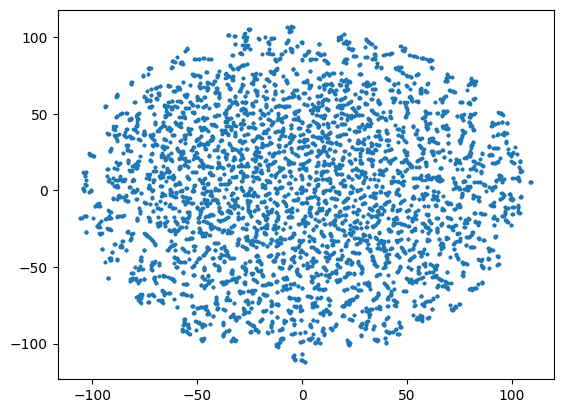

In [6]:
plt.scatter(dish_red[:,0],dish_red[:,1],s=3)

In [5]:
kdTree=KDTree(dish_vecs)

In [10]:
query=list(dish_vecs[10])
kdTree.query(query)

(0.0, 10)

In [12]:
tags=df['tags'].values

In [14]:
import gensim.downloader

In [47]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [48]:
vocab=set(glove_vectors.key_to_index.keys())

In [58]:
DIM=200
vecs=[]
cnt1=0
for tag_list in tags:
    vec=[0]*DIM
    cnt=0
    for v in str(tag_list).split(';'):
        if v in vocab:
            vec+=glove_vectors.get_vector(v,norm=True)
            cnt+=1
    cnt1+=cnt
    if cnt!=0:
        vecs.append([i/cnt for i in vec])
    else:
        vecs.append(vec)

In [59]:
vecs=np.array(vecs)

In [60]:
vecs.shape,dish_vecs.shape

((7280, 200), (7280, 300))

In [61]:
merged=np.concatenate([dish_vecs,vecs],axis=1)

In [37]:
merged.shape

(7280, 400)

In [69]:
dish_red=TSNE(n_components=2,learning_rate='auto',init='random',perplexity=3).fit_transform(merged)

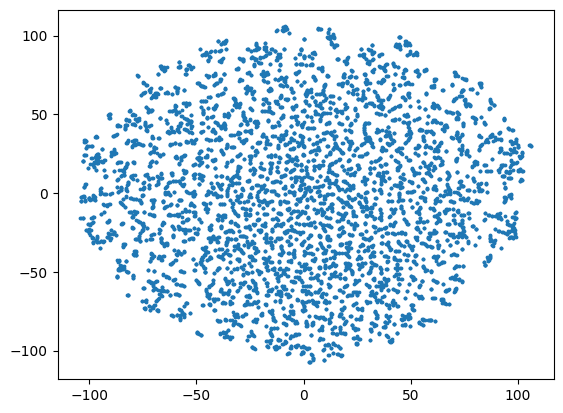

In [70]:
plt.scatter(dish_red[:,0],dish_red[:,1],s=3)

In [40]:
titles=df['recipe_name'].values

In [54]:
title2vec={}
for id,vec in enumerate(merged):
    title2vec[titles[id]]=vec

In [42]:
def sim(v1,v2):
    return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [135]:
i=1243
v1=dish_vecs[i]
scores=[]
for id,v in enumerate(dish_vecs):
    scores.append([sim(v1,v),id])

scores=sorted(scores,reverse=True)

for rec in scores[:5]:
    print(titles[rec[1]])

Miso Soup
Cabbage Fat-Burning Soup
Maryland Crab Soup
Curtido (El Salvadoran Cabbage Salad)
Portuguese Chourico and Peppers


In [139]:
i=3421
v1=merged[i]
scores=[]
for id,v in enumerate(merged):
    scores.append([sim(v1,v),id])

scores=sorted(scores,reverse=True)

for rec in scores[:5]:
    print(titles[rec[1]])

Pig Burger
Bacon Jack Chicken Sandwich
Feta Chicken
Chicken Tetrazzini for a Crowd
Creamy Rice, Chicken and Spinach Dinner


In [111]:
np.random.choice(titles,20)

array(['First Class Bleu Cheese Salad', 'Black-Eyed Pea Soup',
       'No Fail Chocolate Fudge',
       'Caramelized Onion and Gorgonzola Pizza', 'Amish Cookies',
       'Skillet Gnocchi with Chard & White Beans',
       "Santa's Favorite Cake", 'Sauerbraten I', 'Cheesy Catfish Chowder',
       'Chocolate-Zucchini Cupcakes', 'Zippy and Tangy Turkey Rice Soup',
       'Citrus Chicken',
       'Mini Southwestern Corn Pup Muffins with Fiesta Dipping Sauce',
       'Mushroom Rice', 'Gingerbread Cupcakes with Cream Cheese Frosting',
       'Pork Schnitzel with Dipping Sauce',
       "Chef John's Italian Meatballs", 'Peanut Butter Pie XIII',
       'Pumpkin Pastina', 'Chicken in Every Pot Pie'], dtype=object)

In [83]:
def norm(v):
    return v/np.linalg.norm(v)

In [136]:
kdTree_1=KDTree(merged)

In [138]:
id1,id2,id3=1695,947,4062
query=list(norm(merged[id1]-merged[id2]+merged[id3]))
_,id=kdTree_1.query(query,2)
titles[id[1]],id[1],titles[id1],titles[id2],titles[id3]

('Pig Burger',
 3421,
 'Creamy Chicken Lasagna',
 'Italian Lasagna',
 'Western Salad')

In [113]:
from thefuzz import process

In [ ]:
collection = list(titles)

In [152]:
process.extract('Cheese Cake',collection)

[('Cheese Cake Cups', 95),
 ('Ricotta Cheese Cake', 90),
 ('Cherry Cream Cheese Cake', 90),
 ('Cheddar Cheese Straws', 86),
 ('Cheese Biscuits I', 86)]

In [153]:
list(titles).index('Ricotta Cheese Cake')

54

In [154]:
id1,id2,id3,id4=1502,4062,39,54
np.linalg.norm(merged[id1]-merged[id2]+merged[id3]-merged[id4]),np.linalg.norm(dish_vecs[id1]-dish_vecs[id2]+dish_vecs[id3]-dish_vecs[id4])

(3.5465896474182106, 3.5021851944178684)

(2.5231489774422933, 2.4334638388689505)
(3.5465896474182106, 3.5021851944178684)